In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
from glob import glob
import trimesh
from tqdm import tqdm


In [2]:
# Base path to your data folders
base_data_path = "/home/s5722127/MasterClass/data"
subject_id = "FaceTalk_170725_00137_TA"

audio_dir = os.path.join(base_data_path, "audio", subject_id)
mesh_dir = os.path.join(base_data_path, "registereddata", subject_id)

pairs = []

for i in range(1, 41):  # sentence01 to sentence40
    sid = f"sentence{i:02d}"
    audio_path = os.path.join(audio_dir, f"{sid}.wav")
    ply_folder = os.path.join(mesh_dir, sid)

    if os.path.isfile(audio_path) and os.path.isdir(ply_folder):
        pairs.append((audio_path, ply_folder))

print(f"Total valid pairs found: {len(pairs)}")


Total valid pairs found: 40


In [3]:
import torchaudio.transforms as T

# Audio parameters
sample_rate = 16000
n_fft = 400
win_length = 400
hop_length = 160
n_mels = 80

mel_transform = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels
)

def extract_log_mel_spectrogram(audio_path):
    waveform, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        resampler = T.Resample(sr, sample_rate)
        waveform = resampler(waveform)

    mel_spec = mel_transform(waveform)  # [1, n_mels, time]
    log_mel = torch.log(mel_spec + 1e-9)
    return log_mel.squeeze(0).transpose(0, 1)  # [T, 80]


In [4]:
import trimesh

def load_ply_sequence(ply_folder):
    ply_files = sorted([
        os.path.join(ply_folder, f) 
        for f in os.listdir(ply_folder) if f.endswith('.ply')
    ])

    mesh_seq = []
    for path in ply_files:
        mesh = trimesh.load(path, process=False)
        vertices = mesh.vertices.astype(np.float32)  # shape: [5023, 3]
        mesh_seq.append(torch.tensor(vertices))      # Convert to tensor

    return torch.stack(mesh_seq)  # [T, 5023, 3]


In [5]:
from torch.utils.data import Dataset

class SingleSubjectLipSyncDataset(Dataset):
    def __init__(self, base_audio_dir, base_mesh_dir, subject_id):
        self.audio_dir = os.path.join(base_audio_dir, subject_id)
        self.mesh_dir = os.path.join(base_mesh_dir, subject_id)
        self.pairs = []

        for i in range(1, 41):
            sent_id = f"sentence{i:02d}"
            audio_path = os.path.join(self.audio_dir, f"{sent_id}.wav")
            mesh_path = os.path.join(self.mesh_dir, sent_id)
            if os.path.isfile(audio_path) and os.path.isdir(mesh_path):
                self.pairs.append((audio_path, mesh_path))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        audio_path, mesh_folder = self.pairs[idx]
        audio_feat = extract_log_mel_spectrogram(audio_path)
        mesh_seq = load_ply_sequence(mesh_folder)

        min_len = min(audio_feat.shape[0], mesh_seq.shape[0])
        audio_feat = audio_feat[:min_len]
        mesh_seq = mesh_seq[:min_len]

        return audio_feat, mesh_seq


In [6]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def collate_fn(batch):
    audio_batch, mesh_batch = zip(*batch)  # tuples of (T, 80) and (T, 5023, 3)

    # Pad audio sequences
    audio_batch = pad_sequence(audio_batch, batch_first=True)  # [B, max_T, 80]

    # Pad mesh sequences
    max_len = max(m.shape[0] for m in mesh_batch)
    padded_mesh = []
    for m in mesh_batch:
        pad_len = max_len - m.shape[0]
        if pad_len > 0:
            pad_tensor = torch.zeros((pad_len, 5023, 3), dtype=m.dtype)
            m = torch.cat([m, pad_tensor], dim=0)
        padded_mesh.append(m)
    mesh_batch = torch.stack(padded_mesh)  # [B, max_T, 5023, 3]

    return audio_batch, mesh_batch


In [7]:
# Paths
audio_root = "/home/s5722127/MasterClass/data/audio"
mesh_root = "/home/s5722127/MasterClass/data/registereddata"
subject_id = "FaceTalk_170725_00137_TA"

# Dataset and Dataloader
dataset = SingleSubjectLipSyncDataset(audio_root, mesh_root, subject_id)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)


In [8]:
import torch.nn as nn
import math

class LipSyncTransformer(nn.Module):
    def __init__(self, 
                 audio_feat_dim=80, 
                 d_model=256, 
                 nhead=8, 
                 num_layers=6, 
                 output_dim=5023 * 3, 
                 max_seq_len=1000):
        super(LipSyncTransformer, self).__init__()

        self.input_proj = nn.Linear(audio_feat_dim, d_model)

        # Positional encoding
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # shape: [1, max_seq_len, d_model]

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.frame_mixer = nn.Conv1d(d_model, d_model, kernel_size=3, padding=1)
        self.norm = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # x: [B, T, 80]
        B, T, _ = x.shape
        x = self.input_proj(x) + self.pe[:, :T]
        x = self.transformer(x)
        x_mix = self.frame_mixer(x.transpose(1, 2)).transpose(1, 2)
        x = self.norm(x + x_mix)
        x = self.output_proj(x)  # [B, T, 5023*3]
        return x.view(B, T, 5023, 3)


In [9]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LipSyncTransformerVOCA().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Loss functions
mse_loss_fn = nn.MSELoss()
cos_sim = nn.CosineSimilarity(dim=-1)

# Training
model.train()
for epoch in range(num_epochs):
    total_loss = total_mse = total_cos = total_var = total_frame_var = total_smooth = 0.0

    for batch_idx, (audio_input, animation_target) in enumerate(dataloader):
        audio_input = audio_input.to(device)           # [B, T, 80]
        animation_target = animation_target.to(device) # [B, T, 5023, 3]

        optimizer.zero_grad()
        pred = model(audio_input)                      # [B, T, 5023, 3]

        # Base MSE
        mse = mse_loss_fn(pred, animation_target)

        # Cosine similarity between frames
        cos = 1 - cos_sim(pred[:, 1:], pred[:, :-1]).mean()

        # Temporal variation (reward movement)
        temp_diff = pred[:, 1:] - pred[:, :-1]
        var = torch.mean(temp_diff ** 2)

        # Frame-wise vertex variance
        frame_var = pred.var(dim=1).mean()

        # Mesh smoothness (between adjacent vertices)
        smooth = F.mse_loss(pred[:, :, 1:], pred[:, :, :-1])

        # Combined loss
        loss = (mse + 0.01 * cos - 1.0 * var + 0.005 * smooth) / 1.015

        loss.backward()
        optimizer.step()

        # Logging
        total_loss += loss.item()
        total_mse += mse.item()
        total_cos += cos.item()
        total_var += var.item()
        total_frame_var += frame_var.item()
        total_smooth += smooth.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(dataloader)}], "
                  f"Loss: {loss.item():.6f}, MSE: {mse.item():.6f}, Cos: {cos.item():.4f}, "
                  f"TempVar: {var.item():.4f}, FrameVar: {frame_var.item():.4f}, Smooth: {smooth.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"[Epoch {epoch+1}] Avg Loss: {avg_loss:.6f} | MSE: {total_mse/len(dataloader):.6f} | "
          f"Cos: {total_cos/len(dataloader):.4f} | TempVar: {total_var/len(dataloader):.4f} | "
          f"FrameVar: {total_frame_var/len(dataloader):.4f} | Smooth: {total_smooth/len(dataloader):.4f}")

    scheduler.step(avg_loss)

    for param_group in optimizer.param_groups:
        print(f"Learning Rate after epoch {epoch+1}: {param_group['lr']:.6f}")


/home/s5722127/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1] Step 0/40 | Loss: 0.327189 | MSE: 0.334547 | Cos: 0.0782 | Var: 0.0326 | Smooth: 0.6584
[Epoch 1] Step 10/40 | Loss: 0.166501 | MSE: 0.170714 | Cos: 0.1328 | Var: 0.0237 | Smooth: 0.3377
[Epoch 1] Step 20/40 | Loss: 0.078837 | MSE: 0.080188 | Cos: 0.2306 | Var: 0.0163 | Smooth: 0.1588
[Epoch 1] Step 30/40 | Loss: 0.036563 | MSE: 0.036129 | Cos: 0.2969 | Var: 0.0117 | Smooth: 0.0718
Epoch 1 DONE | Avg Loss: 0.112255 | MSE: 0.114374 | Cos: 0.2108 | Var: 0.0184 | Smooth: 0.2264
Learning Rate: 0.000100
[Epoch 2] Step 0/40 | Loss: 0.018075 | MSE: 0.016945 | Cos: 0.2930 | Var: 0.0085 | Smooth: 0.0340
[Epoch 2] Step 10/40 | Loss: 0.010097 | MSE: 0.008796 | Cos: 0.2695 | Var: 0.0067 | Smooth: 0.0183
[Epoch 2] Step 20/40 | Loss: 0.006545 | MSE: 0.005307 | Cos: 0.2309 | Var: 0.0051 | Smooth: 0.0109
[Epoch 2] Step 30/40 | Loss: 0.004936 | MSE: 0.003789 | Cos: 0.2040 | Var: 0.0043 | Smooth: 0.0077
Epoch 2 DONE | Avg Loss: 0.007969 | MSE: 0.006762 | Cos: 0.2353 | Var: 0.0055 | Smooth: 0.0

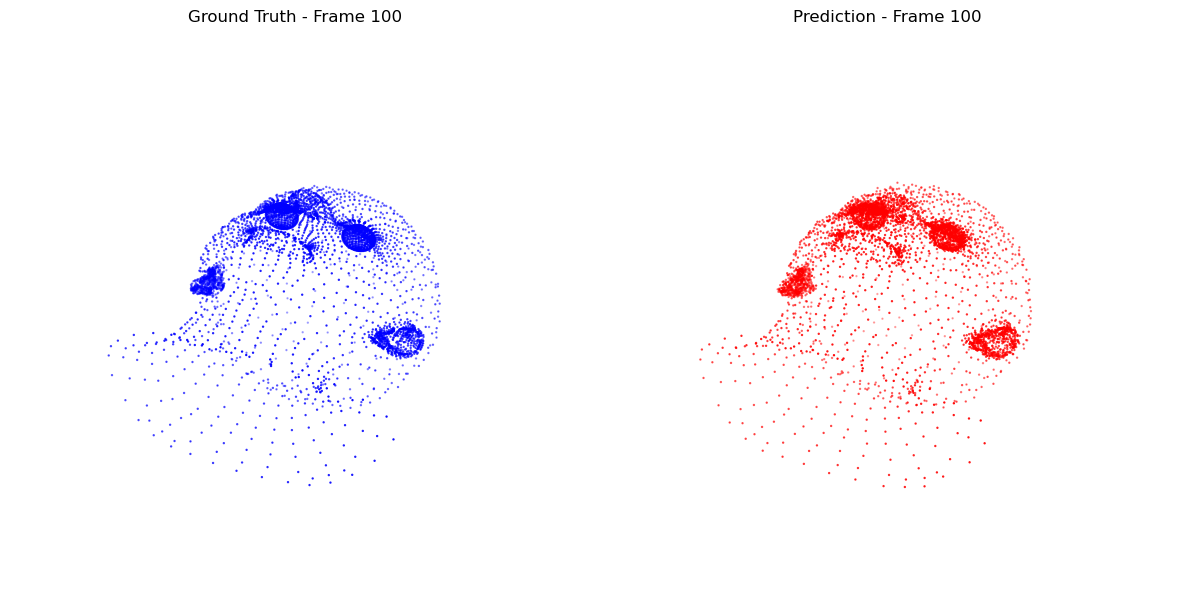

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load one sample
audio_input, gt_mesh = dataset[0]  # Get first sample
audio_input = audio_input.unsqueeze(0).to(device)  # [1, T, 80]

# Predict with model
model.eval()
with torch.no_grad():
    pred_mesh = model(audio_input)[0].cpu().numpy()  # Remove batch dimension

# Ground truth mesh
gt_mesh = gt_mesh.numpy()  # [T, 5023, 3]

# Frame index to visualize
frame_idx = 100
gt_frame = gt_mesh[frame_idx]
pred_frame = pred_mesh[frame_idx]

# Plot comparison
def visualize_frame_comparison(gt_frame, pred_frame, frame_idx=0):
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(gt_frame[:, 0], gt_frame[:, 1], gt_frame[:, 2], s=0.5, c='blue')
    ax1.set_title(f"Ground Truth - Frame {frame_idx}")
    ax1.axis('off')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(pred_frame[:, 0], pred_frame[:, 1], pred_frame[:, 2], s=0.5, c='red')
    ax2.set_title(f"Prediction - Frame {frame_idx}")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

visualize_frame_comparison(gt_frame, pred_frame, frame_idx)


In [12]:
import matplotlib.pyplot as plt

def plot_xy_frame_comparison(ground_truth_mesh, predicted_mesh, frame_idx=10):
    gt_frame = ground_truth_mesh[frame_idx]    # [5023, 3]
    pred_frame = predicted_mesh[frame_idx]     # [5023, 3]

    plt.figure(figsize=(12, 6))

    # Ground Truth
    plt.subplot(1, 2, 1)
    plt.scatter(gt_frame[:, 0], gt_frame[:, 1], s=1, c='blue')
    plt.title(f"Ground Truth - Frame {frame_idx}")
    plt.axis('equal')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.scatter(pred_frame[:, 0], pred_frame[:, 1], s=1, c='red')
    plt.title(f"Prediction - Frame {frame_idx}")
    plt.axis('equal')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [14]:
audio_sample, gt_mesh_sample = next(iter(dataloader))
audio_sample = audio_sample[0].unsqueeze(0).to(device)   # Shape: [1, T, 80]
gt_mesh_sample = gt_mesh_sample[0].cpu().numpy()         # Shape: [T, 5023, 3]


In [15]:
model.eval()
with torch.no_grad():
    pred_mesh = model(audio_sample).cpu().numpy()[0]     # Shape: [T, 5023, 3]


In [16]:
ground_truth_mesh = gt_mesh_sample
predicted_mesh = pred_mesh


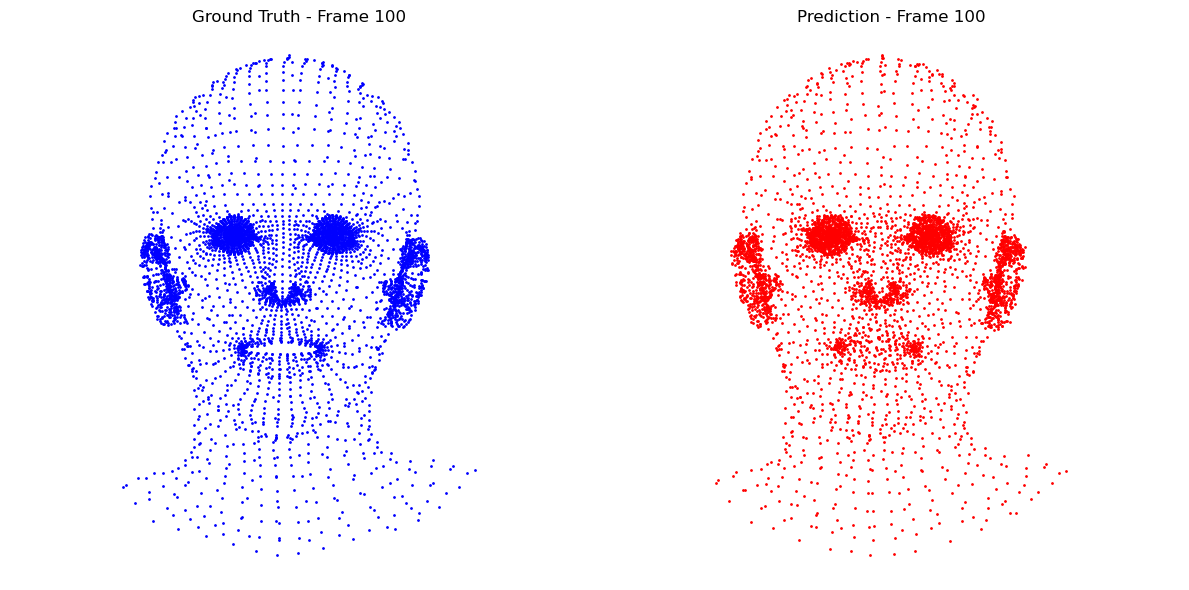

In [29]:
plot_xy_frame_comparison(ground_truth_mesh, predicted_mesh, frame_idx=100)


In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def create_animation(predicted, ground_truth, save_path="animation_comparison.mp4", dpi=150):
    T = min(predicted.shape[0], ground_truth.shape[0])

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    scatters = [axes[0].scatter([], [], s=1), axes[1].scatter([], [], s=1)]

    axes[0].set_title("Ground Truth")
    axes[1].set_title("Prediction")

    for ax in axes:
        ax.set_xlim(-0.1, 0.1)
        ax.set_ylim(-0.1, 0.1)
        ax.set_aspect('equal')
        ax.axis('off')

    def update(frame):
        for i, data in enumerate([ground_truth, predicted]):
            xy = data[frame][:, :2]  # Extract only X and Y
            scatters[i].set_offsets(xy)
        return scatters




    ani = animation.FuncAnimation(
        fig, update, frames=T, interval=50, blit=True
    )
    ani.save(save_path, writer='ffmpeg', dpi=dpi)
    plt.close(fig)
    print(f"Animation saved to {save_path}")


In [23]:
create_animation(predicted_mesh, ground_truth_mesh, save_path="comparisonv8.mp4")


Animation saved to comparisonv8.mp4
